Mounting the drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Loading required modules

In [2]:
import os
import numpy as np
import cv2
import pandas as pd
import tensorflow as tf
from tensorflow import keras
#import tensorflow_addons as tfa
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split
#from vit_keras import vit, utils, visualize
import sklearn

Path to RGB images, before converting the images to .npy array

In [ ]:
data_path = "/content/drive/MyDrive/Datasets/kaggle_data/Cervical Cancer/Cervical Cancer"

Reading images and resizing

In [ ]:
def convert_to_array(data_path, folder):
  data_mat =[]
  folder_data_path = os.path.join(data_path, folder)
  for image in sorted(os.listdir(folder_data_path)):
    print(image)
    image_mat = cv2.imread(os.path.join(data_path, folder, image))

    #doing enhancement using histogram equilization
    #img_hsv = cv2.cvtColor(image_mat, cv2.COLOR_RGB2HSV)
    #img_hsv[:, :, 2] = cv2.equalizeHist(img_hsv[:, :, 2])
    #image_mat = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)

    data_mat.append(cv2.resize(image_mat, (224, 224)))
    #data_mat.append(image_mat)
  return np.array(data_mat)

Saving the images into .npy array

In [ ]:
dys_images = convert_to_array(data_path, 'Dyskeratotic')
print(dys_images.shape)

koi_images = convert_to_array(data_path, 'Koilocytotic')
print(koi_images.shape)

met_images = convert_to_array(data_path, 'Metaplastic')
print(met_images.shape)

par_images = convert_to_array(data_path, 'Parabasal')
print(par_images.shape)

sup_images = convert_to_array(data_path, 'Superficial-Intermediat')
print(sup_images.shape)

Giving labels

In [ ]:
dys_labels = np.zeros(len(dys_images))
koi_labels = np.ones(len(koi_images))
met_labels = 2 * np.ones(len(met_images))
par_labels = 3 * np.ones(len(par_images))
sup_labels = 4 * np.ones(len(sup_images))

Saving the data and corresponding labels

In [ ]:
X = np.concatenate((dys_images, koi_images, met_images, par_images, sup_images))
y = np.concatenate((dys_labels, koi_labels, met_labels, par_labels, sup_labels))

In [ ]:
np.save('/content/drive/MyDrive/Datasets/cervical_image_set/X.npy', X)
np.save('/content/drive/MyDrive/Datasets/cervical_image_set/y.npy', y)

Loading the images that are already saved after resized to 224x224x3

In [3]:
X = np.load('/content/drive/MyDrive/Datasets/cervical_image_set/X.npy')
y = np.load('/content/drive/MyDrive/Datasets/cervical_image_set/y.npy')

Splitting the data into train and test

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=41) # random_state = 42 and random_state = 41

Loading pretrained models

In [20]:
IMAGE_SIZE = (224, 224, 3)

base_model = tf.keras.applications.MobileNetV3Large(include_top = False, input_shape = IMAGE_SIZE, include_preprocessing = True)

gap = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
softmax = tf.keras.layers.Dense(5, activation = 'softmax')(gap)
model = tf.keras.Model(inputs = base_model.input, outputs = softmax)

12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Freezing first 90% of the layers

In [21]:
start = 0
for layer in base_model.layers:
  start = start + 1
  if start <= int(0.9*(len(base_model.layers))):
    layer.trainable = False

In [ ]:
for layer in base_model.layers:
  print(layer.trainable)

In [7]:
model.summary() # Displaying model summary

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv (Conv2D)             │ (None, 112, 112, 16)   │            432 │ rescaling[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_bn                   │ (None, 112, 112, 16)   │             64 │ conv[0][0]             │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 112, 112, 16)   │              0 │ conv_bn[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 16)   │            144 │ activation[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 16)   │             64 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 112, 112, 16)   │              0 │ expanded_conv_depthwi… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            256 │ re_lu[0][0]            │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_bn  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_add (Add)   │ (None, 112, 112, 16)   │              0 │ activation[0][0],      │
│                           │                        │                │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_1_expand    │ (None, 112, 112, 64)   │          1,024 │ expanded_conv_add[0][… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_1_expand_bn │ (None, 112, 112, 64)   │            256 │ expanded_conv_1_expan… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 112, 112, 64)   │              0 │ expanded_conv_1_expan… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_1_depthwis… │ (None, 113, 113, 64)   │              0 │ re_lu_1[0][0]          │
│ (ZeroPadding2D)           │                        │                │                        │
├──────────────────────

 Total params: 3,001,157 (11.45 MB)

 Trainable params: 957,685 (3.65 MB)

 Non-trainable params: 2,043,472 (7.80 MB)

Compile the model

In [22]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

Fit the model

In [23]:
history = model.fit(X_train, y_train, batch_size = 32, epochs = 5, validation_split = 0.1)

Epoch 1/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.7668 - loss: 0.6716 - val_accuracy: 0.9040 - val_loss: 0.2359
Epoch 2/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9954 - loss: 0.0370 - val_accuracy: 0.9860 - val_loss: 0.0426
Epoch 3/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9993 - loss: 0.0089 - val_accuracy: 0.9980 - val_loss: 0.0080
Epoch 4/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9998 - loss: 0.0039 - val_accuracy: 0.9990 - val_loss: 0.0024
Epoch 5/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9997 - loss: 0.0027 - val_accuracy: 1.0000 - val_loss: 0.0014


Plotting training and validation loss and accuracy

In [25]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter( y=history.history['val_loss'], name="val_loss"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter( y=history.history['loss'], name="loss"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter( y=history.history['val_accuracy'], name="val_accuracy"),
    secondary_y=True,
)

fig.add_trace(
    go.Scatter( y=history.history['accuracy'], name="accuracy"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Loss/Accuracy of MobileNetV3L"
)

# Set x-axis title
fig.update_xaxes(title_text="Epoch")

# Set y-axes titles
fig.update_yaxes(title_text="<b>primary</b> Loss", secondary_y=False)
fig.update_yaxes(title_text="<b>secondary</b> Accuracy", secondary_y=True)

fig.show()

Saving the trained model

In [ ]:
model.save('/content/drive/MyDrive/Datasets/cervical_image_set/trained-models/mobilenetv3l-224-adam-0.0001-32-5')

Loading the saved model if required

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Datasets/cervical_image_set/trained-models/mobilenetv3l-224-adam-0.0001-32-5')

In [ ]:
model.summary()

Model evaluation, not used

In [ ]:
score = model.evaluate(X_test, y_test, verbose = 1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
y_prob = model.predict(X_test)
y_pred = np.argmax(y_prob, axis = 1)

157/157 [==============================] - 4s 15ms/step


Several performance metrics

In [ ]:
print(f'Accuracy {sklearn.metrics.accuracy_score(y_test, y_pred)}')

if 1:
  AUC = sklearn.metrics.roc_auc_score(y_test, y_prob, average = 'weighted', multi_class='ovr')
else:
  AUC = sklearn.metrics.roc_auc_score(y_test, y_pred)
print(f'AUC is {AUC}')

target_names = ['Dyskeratotic', 'Koilocytotic', 'Metaplastic', 'Parabasal', 'Superficial Intermediat']

print('F1-score', sklearn.metrics.f1_score(y_test, y_pred, average = 'weighted'))
print(f'Balanced accuracy {sklearn.metrics.balanced_accuracy_score(y_test, y_pred)}')
#print('Average-precision-score', sklearn.metrics.average_precision_score(y_test, y_prob, average = 'weighted'))
print(f'MCC {sklearn.metrics.matthews_corrcoef(y_test, y_pred)}')
print(f'{sklearn.metrics.classification_report(y_test, y_pred, target_names=target_names)}')
#print(f'{sklearn.metrics.precision_recall_fscore_support(y_test, y_prob)}')

Accuracy 0.9992
AUC is 1.0
F1-score 0.9992003019048705
Balanced accuracy 0.9991935385923363
MCC 0.9990006234665544
                         precision    recall  f1-score   support

           Dyskeratotic       1.00      1.00      1.00       998
           Koilocytotic       1.00      1.00      1.00       990
            Metaplastic       1.00      1.00      1.00       989
              Parabasal       1.00      1.00      1.00      1016
Superficial Intermediat       1.00      1.00      1.00      1007

               accuracy                           1.00      5000
              macro avg       1.00      1.00      1.00      5000
           weighted avg       1.00      1.00      1.00      5000



Plotting the confusion matrix

[[0.998998  0.        0.001002  0.        0.       ]
 [0.        0.9969697 0.0030303 0.        0.       ]
 [0.        0.        1.        0.        0.       ]
 [0.        0.        0.        1.        0.       ]
 [0.        0.        0.        0.        1.       ]]


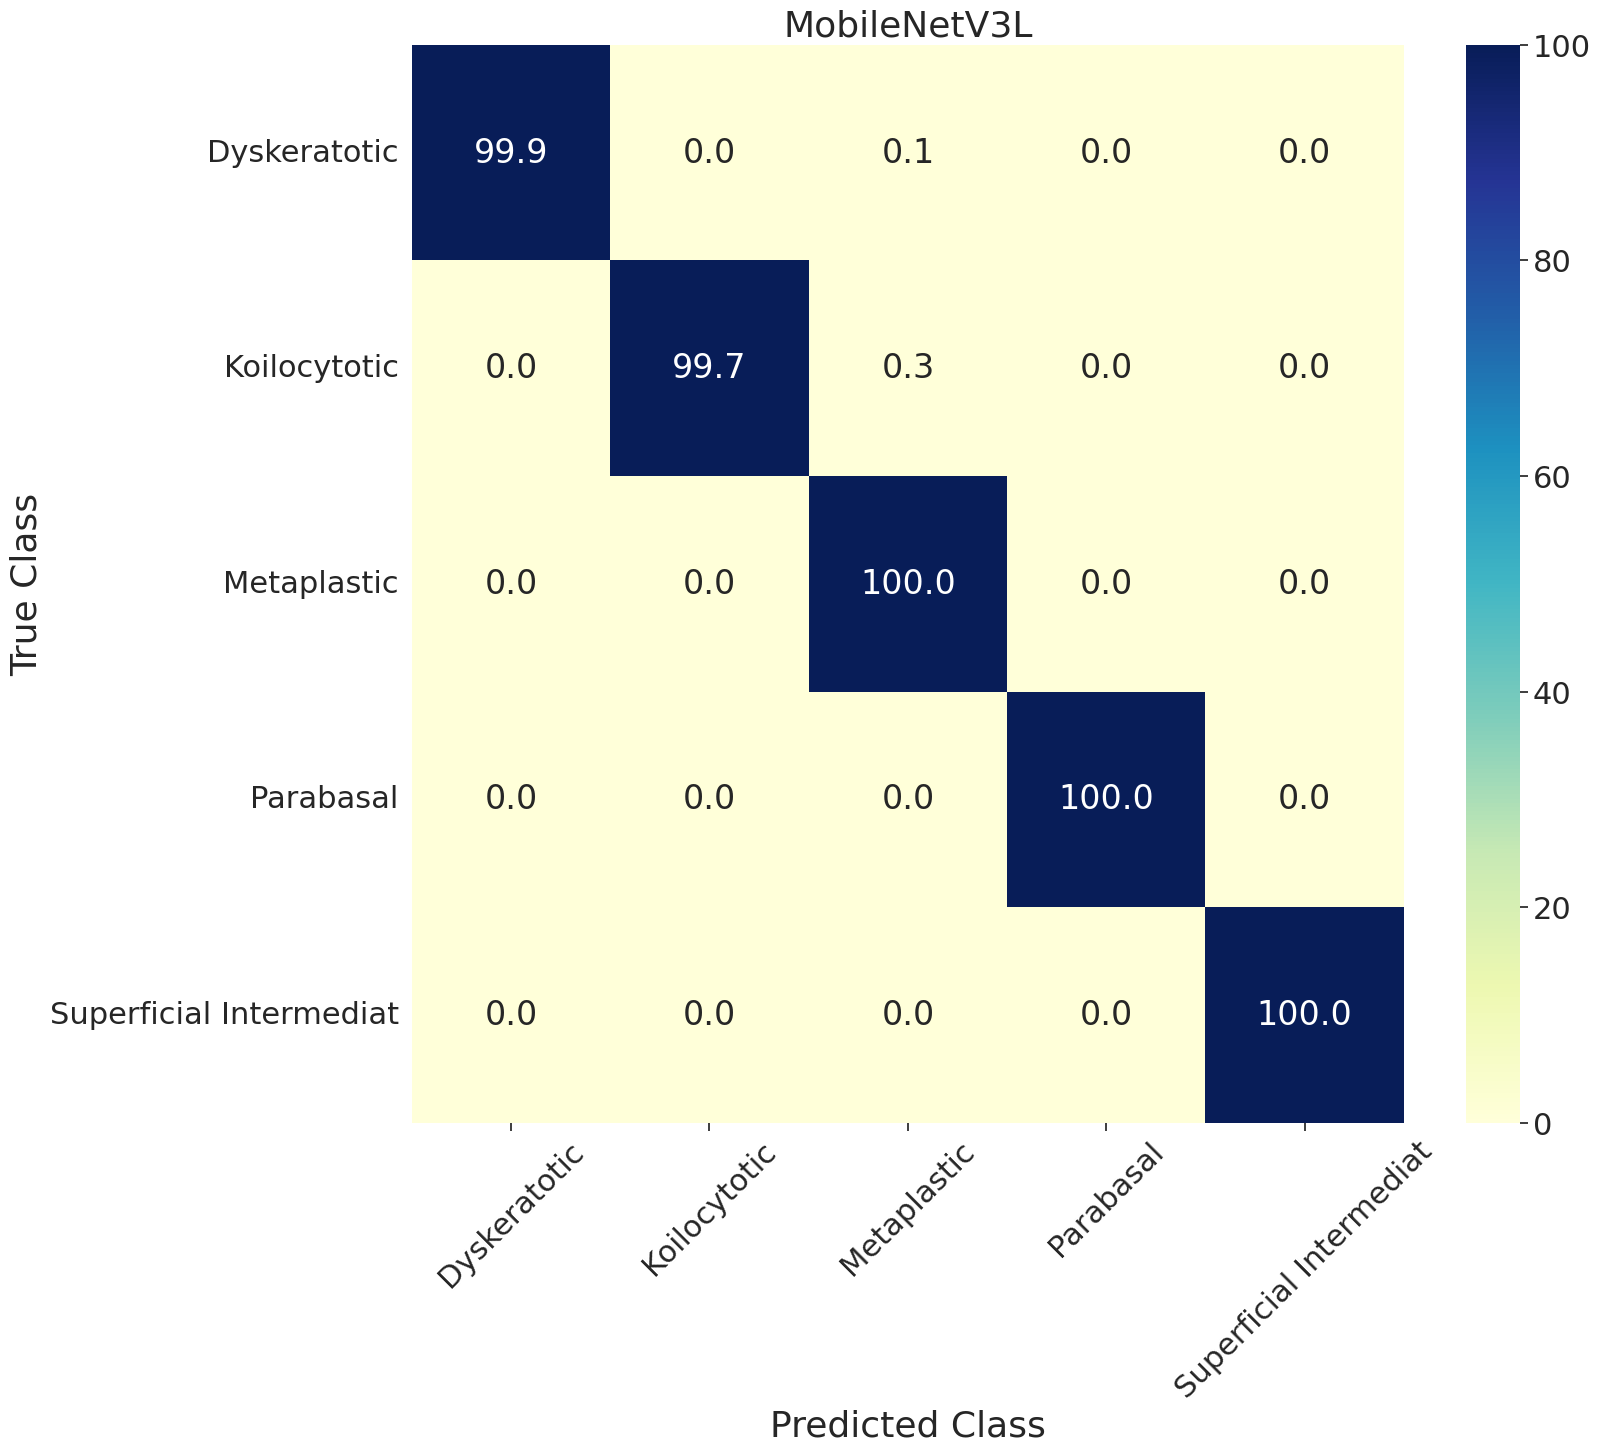

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

confusion_mat = confusion_matrix(y_test, y_pred, normalize = 'true')

if 1:
  class_names = ['Dyskeratotic', 'Koilocytotic', 'Metaplastic', 'Parabasal', 'Superficial Intermediat']
else:
  class_names = ['Bad', 'Good']
print(confusion_mat)

# Plotting multilabel confusion matrix in a beautiful manner
sns.set(font_scale=2)
if 1:
  fig = plt.figure(figsize=(16, 14))
else:
  fig = plt.figure(figsize = (8,6))
ax= plt.subplot()
sns.heatmap(confusion_mat*100, annot=True, vmin = 0, vmax = 100, ax = ax, cmap = 'YlGnBu', fmt = '2.1f'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted Class', fontsize=26)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=45)
ax.xaxis.set_ticklabels(class_names, fontsize = 22)
ax.xaxis.tick_bottom()

ax.set_ylabel('True Class', fontsize=26)
ax.yaxis.set_ticklabels(class_names, fontsize = 22)
plt.yticks(rotation=0)

plt.title('MobileNetV3L', fontsize=26)

plt.show()

gradCAM

In [ ]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output] # Customized for EffNetV2
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
def save_and_display_gradcam(img, heatmap, alpha):

    cam_path="cam.jpg"
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

label: 4.0


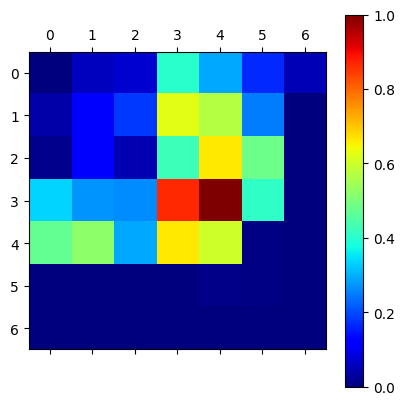

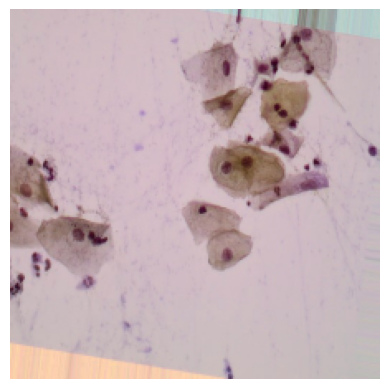

<ipython-input-12-a9759b55c360>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


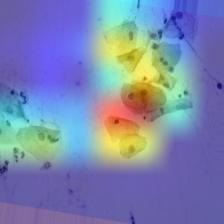

In [ ]:
# 55 for label 0, 556 for label 1, 355 for label 2, 14 for label 3, 110 for label 4
index = 110
img_array = np.expand_dims(X_test[index, :, :, :], axis = 0)
print('label:', y_test[index])

# Generate class activation heatmap
#heatmap = make_gradcam_heatmap(img_array, model, 'convnext_tiny_stage_3_block_2_pointwise_conv_2') # ConvNextTiny
#heatmap = make_gradcam_heatmap(img_array, model, 'top_conv') # EfficientNetV2S
heatmap = make_gradcam_heatmap(img_array, model, 'Conv_1') # MobileNetV3L

# Display heatmap
plt.matshow(heatmap, cmap = 'jet')
plt.colorbar()
plt.show()

# Display original image
plt.imshow(np.squeeze(img_array))
plt.axis('off')
plt.show()

save_and_display_gradcam(np.squeeze(img_array), heatmap, alpha = 1.0)